In [26]:
!pip3 install pathlib
!pip3 install numpy
!pip3 install pandas
!pip3 install multiprocess
!pip3 install matplotlib
!pip3 install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: p

In [27]:
from pathlib import Path
import numpy as np
import pandas as pd
import multiprocess as mp
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = Path("../data/")
out_path = str(path / "endomondoHR_proper.json")

def process(line):
    return eval(line)

pool = mp.Pool(5) 
with open(out_path, 'r') as f:
    data = pool.map(process, f)
pool.close()
pool.join()

In [9]:
df = pd.DataFrame(data)
df = df.dropna()
df

,longitude,altitude,latitude,sport,id,heart_rate,gender,timestamp,url,userId,speed
0,"[24.64977040886879, 24.65014273300767, 24.6509...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[60.173348765820265, 60.173239801079035, 60.17...",bike,396826535,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",male,"[1408898746, 1408898754, 1408898765, 140889877...",https://www.endomondo.com/users/10921915/worko...,10921915,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3..."
1,"[24.649855233728886, 24.65015547350049, 24.650...","[38.4, 39.0, 39.0, 38.2, 36.8, 36.8, 36.8, 35....","[60.173247596248984, 60.17320962622762, 60.172...",bike,392337038,"[100, 105, 111, 110, 108, 115, 126, 130, 132, ...",male,"[1408221682, 1408221687, 1408221699, 140822170...",https://www.endomondo.com/users/10921915/worko...,10921915,"[9.0792, 13.284, 15.9336, 10.9476, 16.1676, 30..."
2,"[24.64995657093823, 24.650197718292475, 24.651...","[76.4, 73.2, 72.4, 73.0, 73.0, 70.8, 69.2, 69....","[60.17326201312244, 60.173205351457, 60.172969...",bike,389643739,"[99, 105, 113, 110, 109, 110, 108, 121, 116, 1...",male,"[1407858459, 1407858466, 1407858478, 140785849...",https://www.endomondo.com/users/10921915/worko...,10921915,"[4.0464, 13.8204, 16.9776, 19.9404, 28.7856, 3..."
3,"[24.649874344468117, 24.650242729112506, 24.65...","[28.6, 29.4, 29.4, 29.4, 28.0, 27.0, 25.2, 23....","[60.173286236822605, 60.17323946580291, 60.173...",bike,386729739,"[99, 105, 113, 109, 112, 116, 116, 114, 114, 1...",male,"[1407432042, 1407432048, 1407432056, 140743206...",https://www.endomondo.com/users/10921915/worko...,10921915,"[7.4988, 15.4008, 17.8668, 21.5712, 24.1416, 3..."
6,"[24.64981692843139, 24.649868477135897, 24.650...","[24.0, 24.0, 24.0, 21.0, 18.6, 17.4, 17.4, 17....","[60.17327919602394, 60.17327232286334, 60.1732...",bike (transport),381185226,"[118, 118, 119, 120, 122, 124, 126, 129, 133, ...",male,"[1406647079, 1406647080, 1406647082, 140664708...",https://www.endomondo.com/users/10921915/worko...,10921915,"[7.218, 9.8208, 14.3532, 16.2972, 20.1276, 20...."
...,...,...,...,...,...,...,...,...,...,...,...
167678,"[10.235085301101208, 10.23501405492425, 10.234...","[43.2, 42.8, 43.0, 42.8, 42.6, 42.4, 42.0, 41....","[56.24161155894399, 56.24161256477237, 56.2415...",run,355117926,"[71, 71, 77, 79, 86, 91, 94, 99, 104, 109, 113...",male,"[1402436897, 1402436899, 1402436902, 140243690...",https://www.endomondo.com/users/431375/workout...,431375,"[1.008, 2.6856, 3.1248, 6.4476, 6.7176, 7.6572..."
167679,"[10.23538009263575, 10.235328124836087, 10.235...","[53.4, 53.6, 54.0, 54.4, 55.0, 55.8, 55.8, 55....","[56.24169923365116, 56.24167953617871, 56.2416...",run,354544822,"[62, 64, 70, 77, 84, 90, 93, 98, 103, 106, 109...",male,"[1402353898, 1402353900, 1402353903, 140235390...",https://www.endomondo.com/users/431375/workout...,431375,"[4.3992, 2.2824, 5.2056, 10.8144, 12.9672, 13...."
167680,"[10.235484866425395, 10.235529290512204, 10.23...","[48.8, 48.8, 48.6, 48.2, 48.0, 47.8, 47.8, 47....","[56.24183795414865, 56.24171373434365, 56.2416...",run,350482983,"[67, 76, 81, 84, 95, 101, 107, 110, 111, 113, ...",male,"[1401744403, 1401744408, 1401744413, 140174441...",https://www.endomondo.com/users/431375/workout...,431375,"[0.0324, 6.1128, 10.7136, 13.302, 10.3464, 9.3..."
167685,"[10.23540934547782, 10.235416637733579, 10.235...","[62.4, 62.4, 62.4, 62.6, 62.8, 62.2, 61.6, 60....","[56.24191464856267, 56.24189218506217, 56.2418...",run,341269673,"[69, 69, 72, 81, 84, 91, 94, 102, 105, 109, 11...",male,"[1400360624, 1400360625, 1400360627, 140036063...",https://www.endomondo.com/users/431375/workout...,431375,"[0.7056, 1.6452, 3.5604, 7.9272, 9.5076, 12.06..."


In [ ]:
def plot_timed_graph(df):
    

,longitude,altitude,latitude,sport,id,heart_rate,gender,timestamp,url,userId,speed
0,"[24.64977040886879, 24.65014273300767, 24.6509...","[41.6, 40.6, 38.4]","[60.173348765820265, 60.173239801079035, 60.17...",bike,396826535,"[100, 111, 120]",male,"[1408898746, 1408898754, 1408898765]",https://www.endomondo.com/users/10921915/worko...,10921915,"[6.8652, 16.4736, 19.1988]"


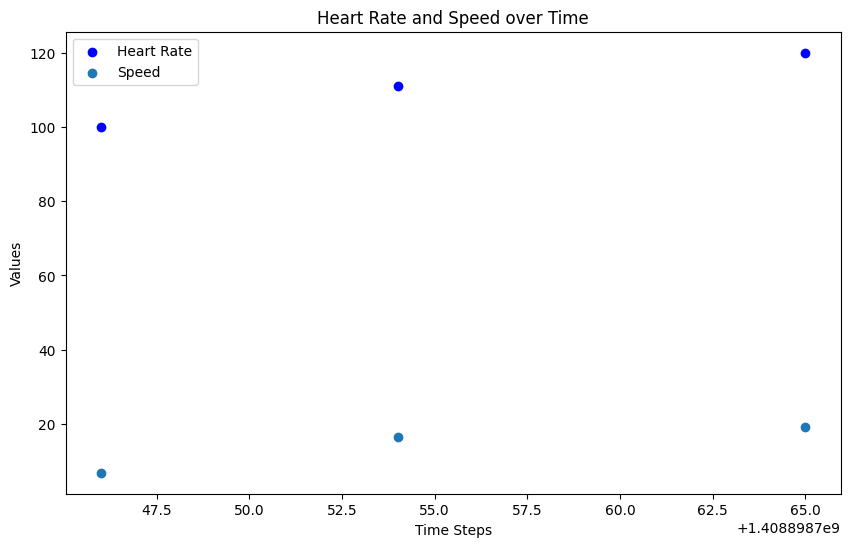

In [42]:
# sport_type_list = df['sport'].unique()
# for sport_type in sport_type_list:
#     typed_df = df[df['sport'] == sport_type]
    
# df[df.index == 0]
# sns.lmplot(data=df[df.index == 0], x='heart_rate', y='speed')
df = pd.DataFrame({
    'longitude': [[24.64977040886879, 24.65014273300767, 24.650910682976246]],
    'altitude': [[41.6, 40.6, 38.4]],
    'latitude': [[60.173348765820265, 60.173239801079035, 60.17298021353781]],
    'sport': ['bike'],
    'id': [396826535],
    'heart_rate': [[100, 111, 120]],
    'gender': ['male'],
    'timestamp': [[1408898746, 1408898754, 1408898765]],
    'url': ['https://www.endomondo.com/users/10921915/workout/396826535'],
    'userId': [10921915],
    'speed': [[6.8652, 16.4736, 19.1988]]
})

display(df)
# Plotting
plt.figure(figsize=(10, 6))

for index, row in df.iterrows():
    plt.scatter(row['timestamp'], row['heart_rate'], label='Heart Rate', c='blue')
    plt.scatter(row['timestamp'], row['speed'], label='Speed')

plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Heart Rate and Speed over Time')
plt.legend()
plt.show()


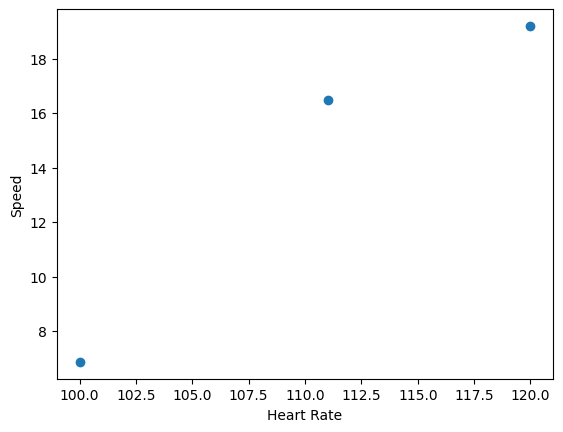

In [43]:
plt.scatter(df.loc[0,'heart_rate'], df.loc[0, 'speed'])
plt.xlabel('Heart Rate')
plt.ylabel('Speed')
plt.show()